# A Time Series Analysis of the Energy Production of Wind Power Turbines in Nova Scotia, Canada from January 2008 to December 2019

## Objective

This report aims to analyze the time series evolution of the energy production from wind power turbines in Nova Scotia from January 2008 to December 2019. In a way, the modelling should help the New Brunswick government and private sector in allocating energy resources and predict how much of their energy should come from wind turbines.

## Description of the Dataset

The dataset is provided by Statistics Canada at https://doi.org/10.25318/2510001501-eng. It measures the energy produced from different sources like hydraulic turbines, steam turbines, wind tubines and so on. The total energy is measured *monthly* in all provinces, and is measured in Megawatt-hours (Mwh). 

For this report, we will be focusing on the energy generated by wind power turbines in Nova Scotia. According to the website where the dataset is held, a wind power turbine is a *power plant in which the prime mover is a wind turbine. Electric power is generated by the conversion of wind power into mechanical energy.*

## Exploratory Data Analysis

In [1]:
# Load the needed libraries
invisible(library(ggplot2))
library(lmtest)
invisible(library(forecast))
library(gridExtra)

# Load the dataset
raw_data <- read.csv(file = "wind_ns.csv", sep = ",")[ ,12]
ts_raw <- ts(raw_data,start=c(2008,1),deltat=1/12)

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Loading required package: zoo

Attaching package: ‘zoo’

The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric

Registered S3 method overwritten by 'xts':
  method     from
  as.zoo.xts zoo 
Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Registered S3 methods overwritten by 'forecast':
  method             from    
  fitted.fracdiff    fracdiff
  residuals.fracdiff fracdiff


In [2]:
# function to calculate accuracy measures

accuracy_meas <- function(raw,fits){
    # for this function to work, we must have length(raw) == length(fits)
    n = length(raw)
    return (data.frame(MAPE =(1/n)*sum(abs(raw-fits)/raw) * 100,
                       MAD = (1/n)*sum(abs(raw-fits)),
                       MSD = (1/n)*sum((raw-fits)^2)))
}


# function to calculate Ljung-Box statistic for lags 12, 24, 36 and 48

Ljung_Box <- function(resid){
    LBQ_stat <- numeric(4)
    lag_seq <- c(12,24,36,48)
    
    k = 1
    for (L in lag_seq){
        LBQ_stat[k] = Box.test(resid, lag = L)$p.value
        k = k+1
    }
    return (data.frame(lag=lag_seq,LBQ=LBQ_stat))
}

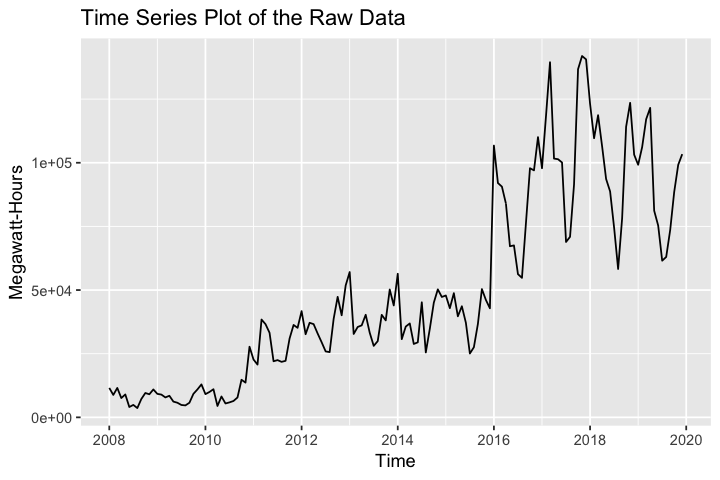

In [3]:
options(repr.plot.width=6, repr.plot.height=4, repr.plot.pointsize=30)
autoplot(ts_raw,main="Time Series Plot of the Raw Data",xlab="Time",ylab="Megawatt-Hours")

### Observations

 - **Trend:** the plot has an increasing trend, we could perhaps, fit a cubic trend to the data
 - **Seasonality:** Since we are dealing with monthly data, there might be a seasonality of length 12.
 - **Stability of the Variance**: the variance seems to increase in time, which can be stabilized by either taking the log-transform or fitting a multiplicative model.
 - **Other Observations**: a sudden increase in wind power generation can be seen in 2011 and 2016. We can perhaps attribute this to the fact that Nova Scotia is building more and more wind power turbines every year. The time series of the wind energy capacity of Nova Scotia is shown below.
 
Source : https://canwea.ca/wp-content/uploads/2020/03/canwea-installedcapacity-v2.pdf

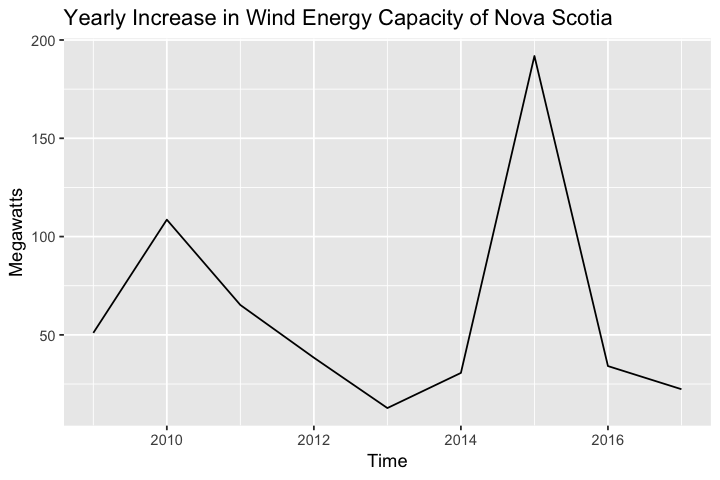

In [4]:
yearly_increase <- c(51,108.6,65.2,38.4,12.77,30.65,191.85,34.13,22.35)
wind_inc <- ts(yearly_increase,start=c(2009,1),deltat=1)
autoplot(wind_inc,main="Yearly Increase in Wind Energy Capacity of Nova Scotia",xlab="Time",ylab="Megawatts")

## Model 1. Log-Transformed Data

We first take the log-transform of the data:

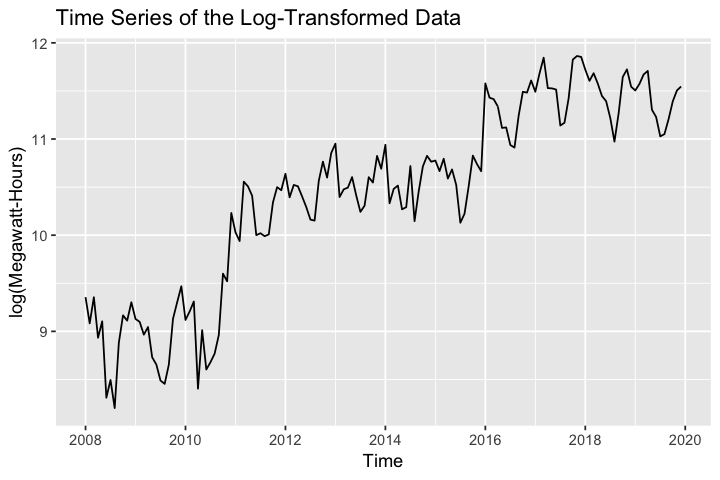

In [5]:
log_data <- log(raw_data)
log_ts <- ts(log_data,start=c(2008,1),deltat=1/12)
autoplot(log_ts,main="Time Series of the Log-Transformed Data",xlab="Time",ylab="log(Megawatt-Hours)")

The variance stabilized quite a bit. Now we fit a cubic curve to the data:

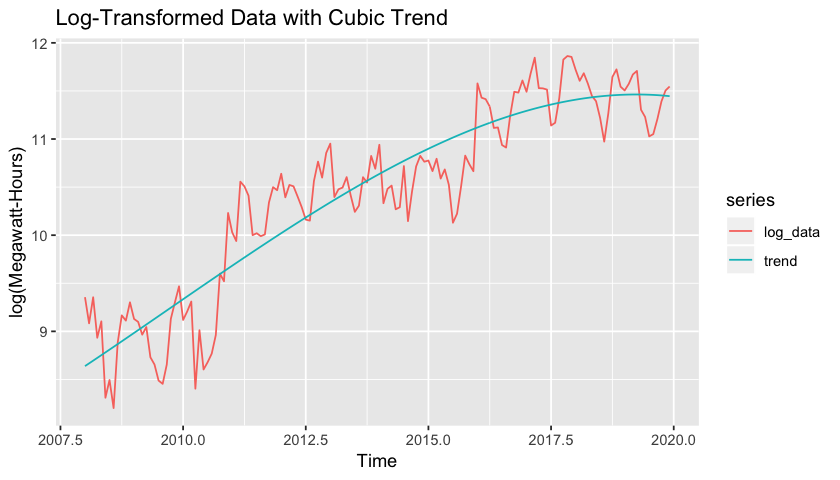

In [6]:
# fit a cubic trend
times = 1:length(log_data)
trend_model <- lm(log_data ~ times + I(times^2) + I(times^3))
trend <- trend_model$fitted.values
combined <- cbind(log_data,trend)
combined_ts <- ts(combined,start=c(2008,1),deltat=1/12)
options(repr.plot.width=7, repr.plot.height=4, repr.plot.pointsize=30)
autoplot(combined_ts,facets=FALSE,main="Log-Transformed Data with Cubic Trend",xlab="Time",ylab="log(Megawatt-Hours)")

In [7]:
# coefficients?
trend_model$coefficients

(Intercept)         times    I(times^2)    I(times^3) 
 8.610415e+00  2.820353e-02  4.844693e-05 -7.470265e-07

Thus, we can write the cubic trend as $m_t = 8.6104 + 0.028t + 0.0000484t^2 - 0.000000747t^3$. Now we store the forecasts and detrend the data:

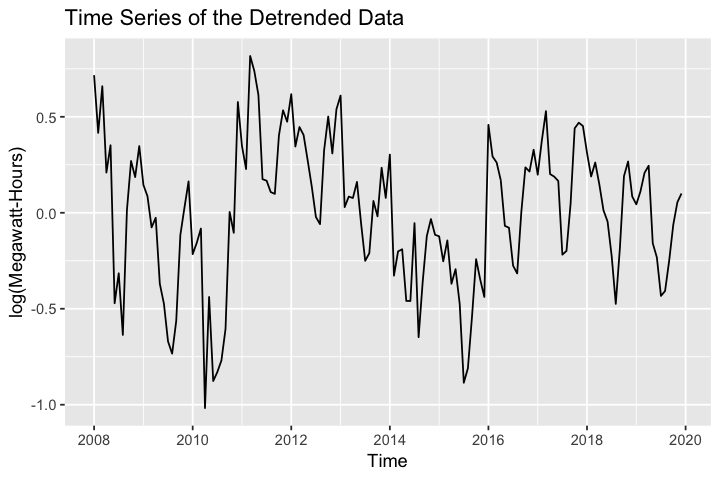

In [8]:
# store next four forecasts from trend
L = length(log_data)
newdata <- data.frame(times = c(L+1,L+2,L+3,L+4))
forecast_trend <- predict(trend_model,newdata)

# detrend the data
detrend_data <- log_data-trend
detrend_ts <- ts(detrend_data,start=c(2008,1),deltat=1/12)
options(repr.plot.width=6, repr.plot.height=4, repr.plot.pointsize=30)
autoplot(detrend_ts,main="Time Series of the Detrended Data",ylab="log(Megawatt-Hours)")

We then do a (classical) decomposition of the data:

 [1]  0.28466624  0.11148928  0.23035502  0.04930574 -0.01561814 -0.22427061
 [7] -0.33437371 -0.42975361 -0.16270726  0.12389047  0.15099327  0.21602330


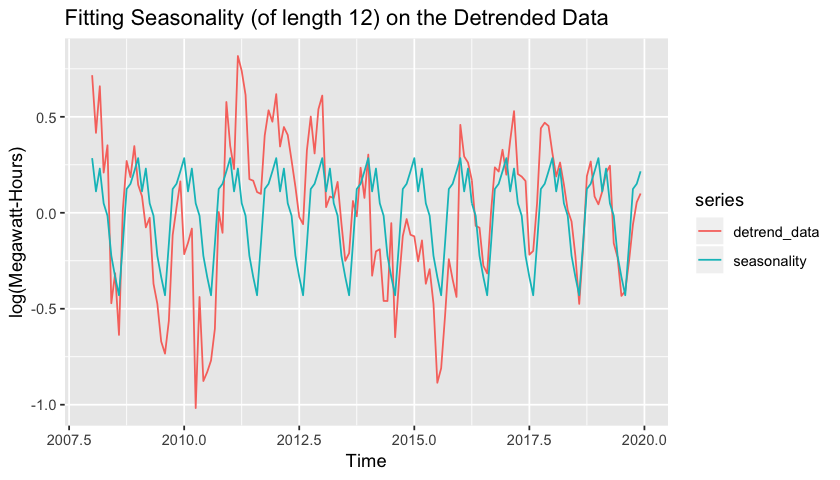

In [9]:
seasonal <- function(data,season_length){
    # this function can work if mod(length(data),season_length) == 0
    season_comps = numeric(season_length)
    
    for (comp in 1:season_length){
        season_comps[comp] = mean(data[seq(comp,length(data),season_length)])
        }
    
    return(season_comps)
    }

season_comps <- seasonal(detrend_data,12)
print(season_comps)
seasonality <- rep(season_comps,floor(length(detrend_data)/12))
detrend_season <- cbind(detrend_data,seasonality)
combined <- ts(detrend_season, start = c(2008,1), deltat = 1/12)
options(repr.plot.width=7, repr.plot.height=4, repr.plot.pointsize=30)
autoplot(combined, main = "Fitting Seasonality (of length 12) on the Detrended Data",ylab="log(Megawatt-Hours)")

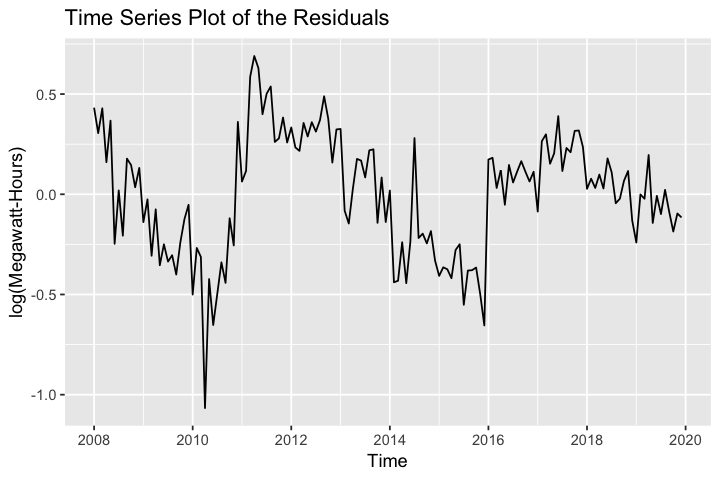

In [10]:
resid = detrend_data - rep(season_comps,floor(length(detrend_data)/12))
resid_ts = ts(resid, start=c(2008,1), deltat = 1/12)
options(repr.plot.width=6, repr.plot.height=4, repr.plot.pointsize=30)
autoplot(resid_ts, main="Time Series Plot of the Residuals",ylab="log(Megawatt-Hours)")

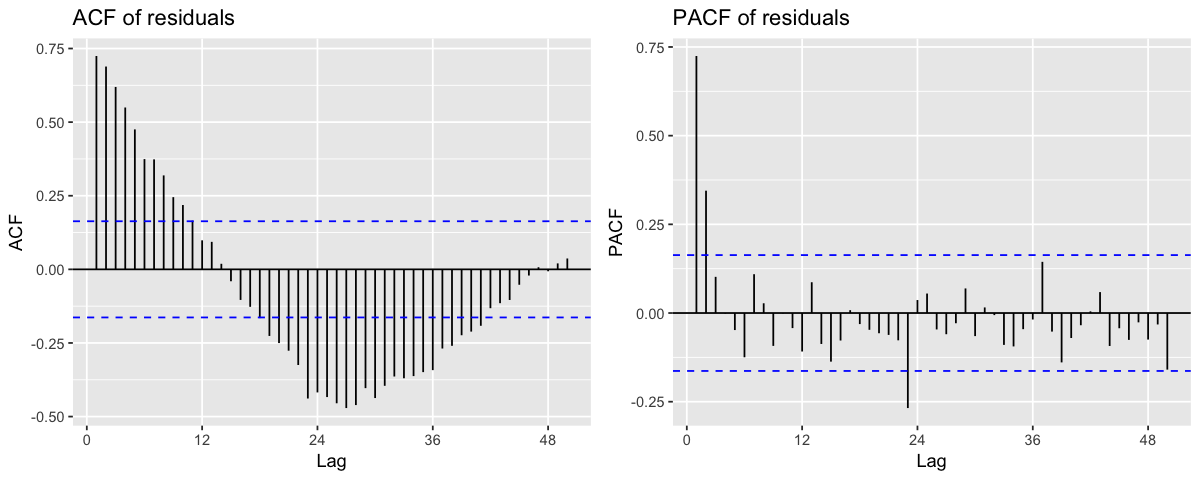

In [11]:
# Check the ACF and PACF
p1 <- ggAcf(resid_ts,lag.max=50) + ggtitle("ACF of residuals")
p2 <- ggPacf(resid_ts,lag.max=50) + ggtitle("PACF of residuals")
options(repr.plot.width=10, repr.plot.height=4, repr.plot.pointsize=30)
grid.arrange(p1,p2,nrow=1)

We can see that the ACF exponentially decays while the PACF cuts off at lag 2. Thus, we could try and fit an $\text{AR}(2)$ process on the residuals:

In [12]:
model1 <- Arima(resid, order=c(2,0,0),include.constant=FALSE)
coeftest(model1)


z test of coefficients:

    Estimate Std. Error z value  Pr(>|z|)    
ar1 0.474426   0.077589  6.1146 9.681e-10 ***
ar2 0.351283   0.077846  4.5125 6.405e-06 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


Notice that the $p$-values for both $\phi_1$ and $\phi_2$ are less than $0.05$, thus no model reduction is necessary. Now we check whether the residuals from the model follow a white noise:

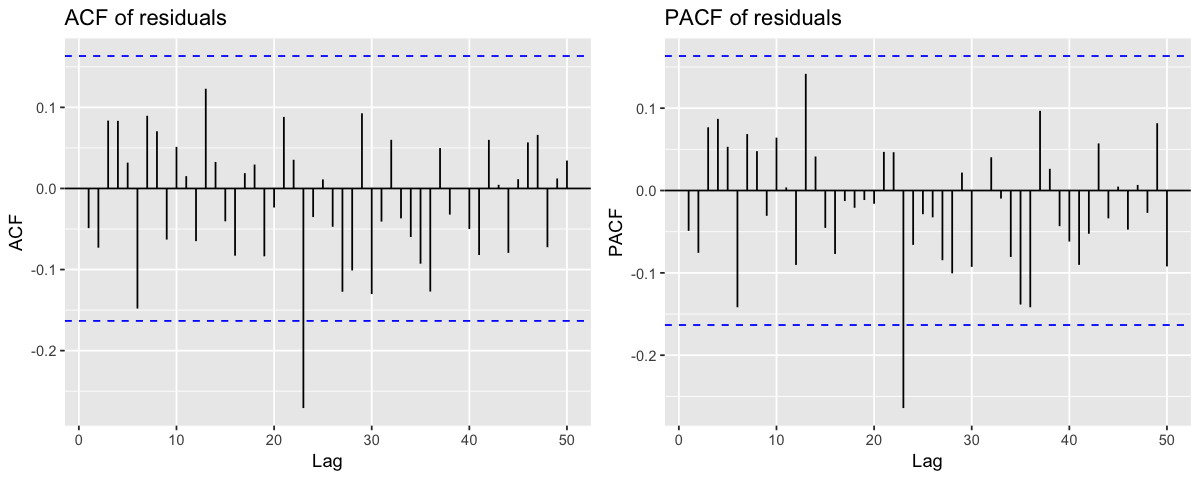

In [13]:
# Check the ACF and PACF
p1 <- ggAcf(model1$residuals,lag.max=50) + ggtitle("ACF of residuals")
p2 <- ggPacf(model1$residuals,lag.max=50) + ggtitle("PACF of residuals")

options(repr.plot.width=10, repr.plot.height=4, repr.plot.pointsize=30)
grid.arrange(p1,p2,nrow=1)

Both ACF and PACF show a significant autocorrelation / partial autocorrelation at lag 23, but this is too far away, and we can just treat the residuals as white noise. Just to make sure, we do a four-in-one plot of the residuals.

In [14]:
# Check Ljung-Box statistic
print(Ljung_Box(model1$residuals))

  lag       LBQ
1  12 0.6255697
2  24 0.3161802
3  36 0.3118189
4  48 0.6069801


We can see from the Ljung-Box statistic that there are no significant autocorrelations at lags 12, 24, 36 and 48.

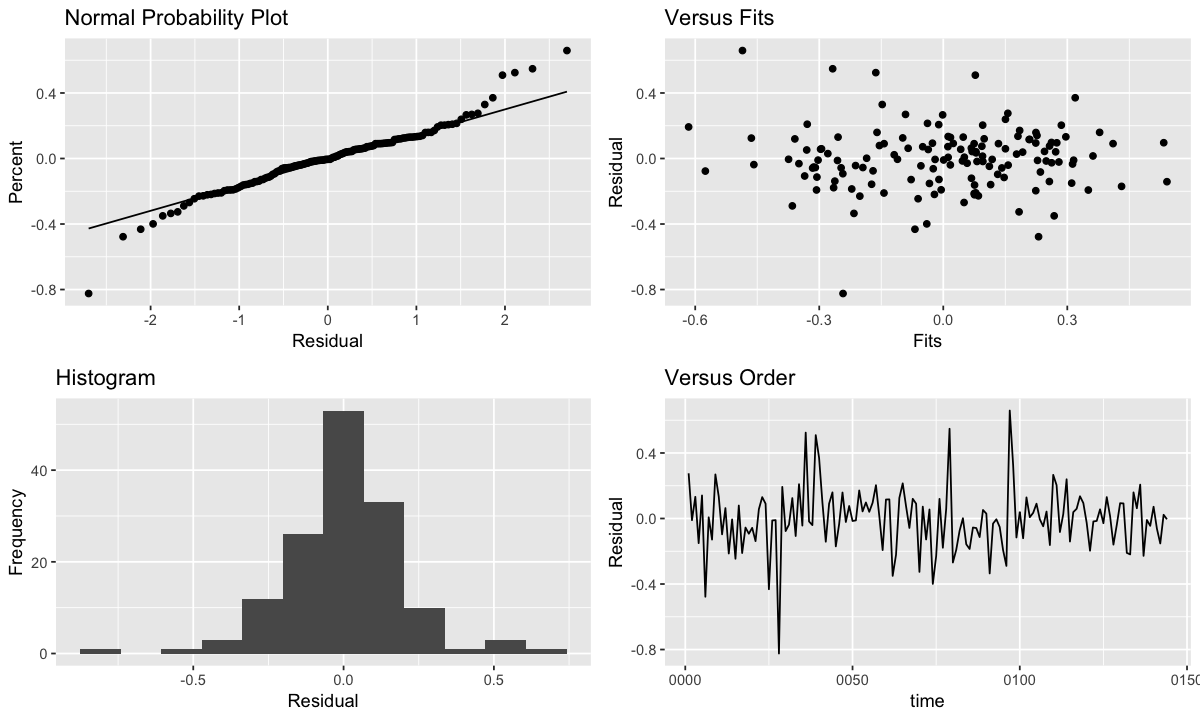

In [15]:
p1 <- ggplot() + 
    geom_qq(aes(sample=as.matrix(model1$residuals))) + 
    geom_qq_line(aes(sample=as.matrix(model1$residuals))) +
    ggtitle("Normal Probability Plot") + 
    xlab("Residual") +
    ylab("Percent")

v_fit = data.frame(Fits=as.matrix(fitted(model1)),
                   Residual=as.matrix(model1$residuals),
                   time=as.Date(time(model1$residuals)))

p2 <- ggplot(v_fit,aes(x=Fits,y=Residual)) + geom_point()+ggtitle("Versus Fits")

p3 <- ggplot(v_fit,aes(x=Residual)) + geom_histogram(bins=12) + ggtitle("Histogram") + ylab("Frequency")

p4 <- ggplot(v_fit,aes(x=time,y=Residual)) + geom_line() + ggtitle("Versus Order")

options(repr.plot.width=10, repr.plot.height=6, repr.plot.pointsize=30)
grid.arrange(p1,p2,p3,p4)

It seems like we do get a white noise. As the constant variance and independence assumptions are not violated.

So now we generate four forecasts for the ARIMA model and plot the fits, forecasts and the original data together:

In [16]:
forecast_ARIMA <- forecast(model1,h=4,level=95)
forecast_actual <- exp((as.matrix(forecast_ARIMA$mean))+forecast_trend+season_comps[1:4])
forecast_low <- exp((as.matrix(forecast_ARIMA$lower))+forecast_trend+season_comps[1:4])
forecast_high <- exp((as.matrix(forecast_ARIMA$upper))+forecast_trend+season_comps[1:4])
fits_total <- exp(trend + rep(season_comps,floor(length(detrend_data)/12))+as.matrix(fitted(model1)))

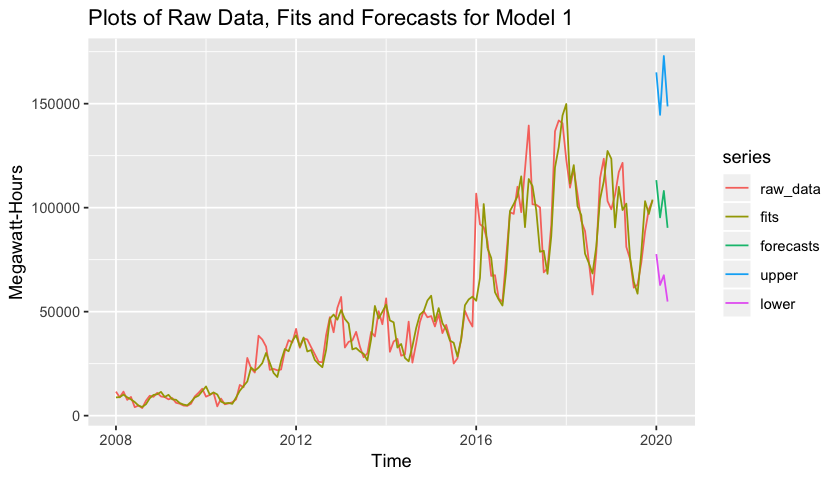

In [17]:
raw_data <- ts(raw_data,start=c(2008,1),deltat=1/12)
fits <- ts(fits_total,start=c(2008,1),deltat=1/12)
forecasts <- ts(forecast_actual,start=c(2020,1),deltat=1/12)
upper <- ts(forecast_high,start=c(2020,1),deltat=1/12)
lower <- ts(forecast_low,start=c(2020,1),deltat=1/12)

options(repr.plot.width=7, repr.plot.height=4, repr.plot.pointsize=30)
comb_ts <- cbind(raw_data,fits,forecasts,upper,lower)
autoplot(comb_ts,main="Plots of Raw Data, Fits and Forecasts for Model 1",ylab="Megawatt-Hours")

The fits and forecasts seem reasonable given the data. Now we solve for the accuracy measures.

In [18]:
acc_meas1 <- accuracy_meas(as.matrix(raw_data),as.matrix(fits))
print(acc_meas1)

      MAPE      MAD      MSD
1 14.02968 6107.949 93921995


So for Model 1, $\text{MAPE} = 14.03$, $\text{MAD} = 6107.95$ and $\text{MSD} = 9.39 \times 10^7$.

## Model 2. Multiplicative Model

We now try a multiplicative model for the original data:

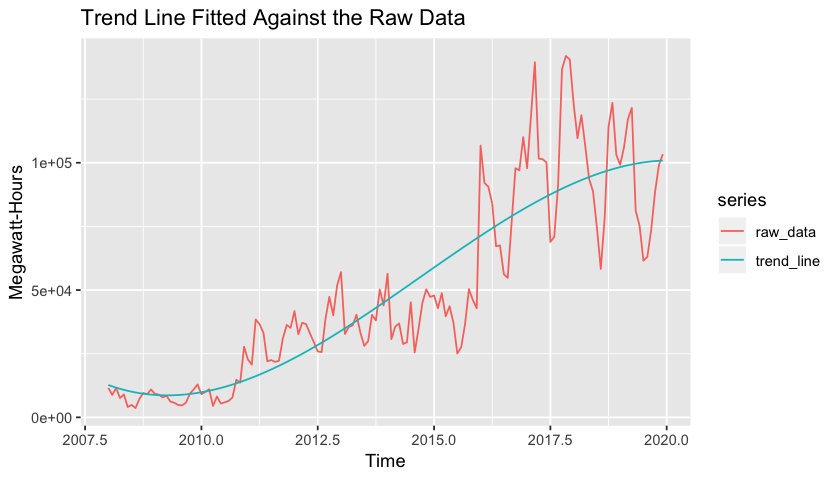

In [19]:
# fit a cubic trend
times = 1:length(raw_data)
trend <- lm(raw_data ~ times + I(times^2) + I(times^3))
trend_line <- trend$fitted.values
combined_ts <- ts(cbind(raw_data,trend_line),start=c(2008,1),deltat=1/12)
autoplot(combined_ts,main="Trend Line Fitted Against the Raw Data",ylab="Megawatt-Hours")

In [20]:
# coefficients?
trend$coefficients

(Intercept)         times    I(times^2)    I(times^3) 
 1.328377e+04 -5.960415e+02  2.046289e+01 -8.402833e-02

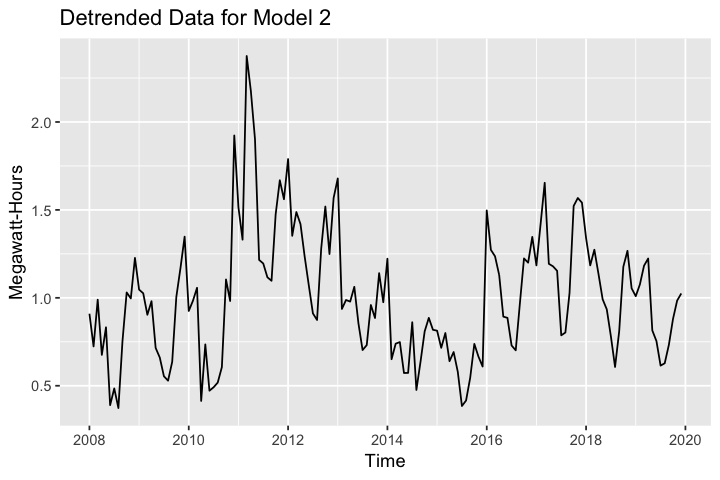

In [21]:
L = length(raw_data)
newdat <- data.frame(times=c(L+1,L+2,L+3,L+4))
forecast_trend <- predict(trend,newdat)

# detrend the data
detrend_data <- raw_data/trend_line
detrend_ts <- ts(detrend_data,start=c(2008,1),deltat=1/12)

options(repr.plot.width=6, repr.plot.height=4, repr.plot.pointsize=30)
autoplot(detrend_ts,main="Detrended Data for Model 2",ylab="Megawatt-Hours")

 [1] 1.2442082 1.0558200 1.2238401 1.0596213 0.9689130 0.7953581 0.7079205
 [8] 0.6477265 0.8377345 1.1142319 1.1480662 1.2496355


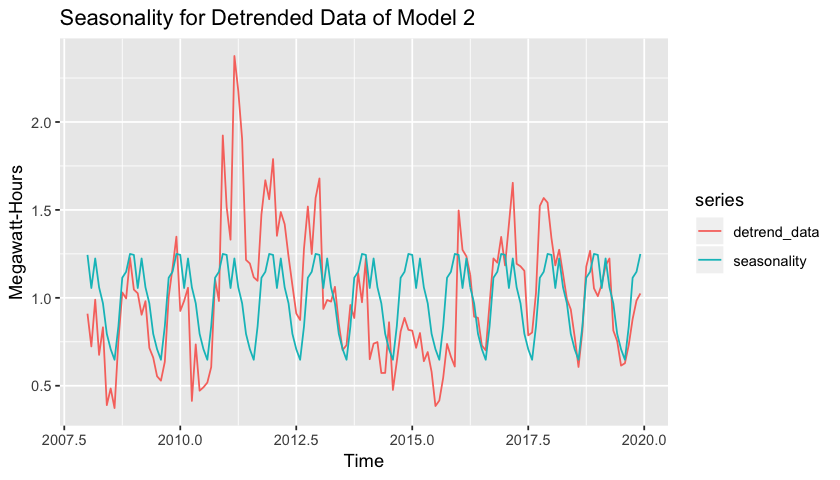

In [22]:
# check seasonality
season_comps <- seasonal(detrend_data,12)
print(season_comps)
seasonality <- rep(season_comps,floor(length(detrend_data)/12))
detrend_season <- cbind(detrend_data,seasonality)
combined <- ts(detrend_season, start = c(2008,1), deltat = 1/12)
options(repr.plot.width=7, repr.plot.height=4, repr.plot.pointsize=30)
autoplot(combined,main="Seasonality for Detrended Data of Model 2",ylab="Megawatt-Hours")

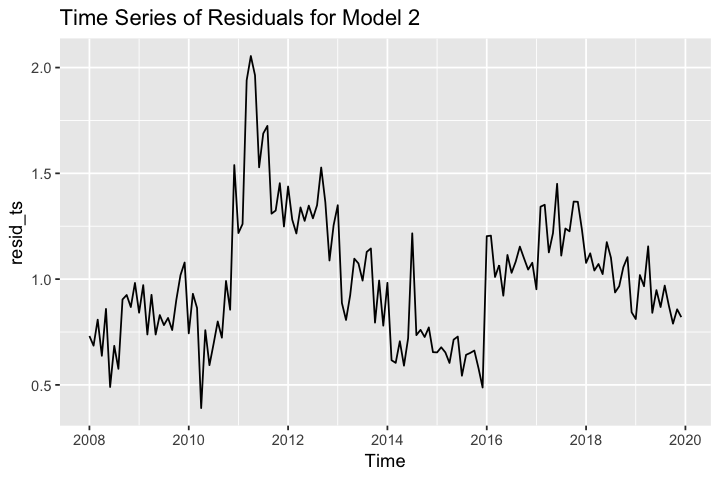

In [23]:
resid = detrend_data/rep(season_comps,floor(length(detrend_data)/12))
resid_ts <- ts(resid,start=c(2008,1),deltat=1/12)
options(repr.plot.width=6, repr.plot.height=4, repr.plot.pointsize=30)
autoplot(resid_ts,main="Time Series of Residuals for Model 2")

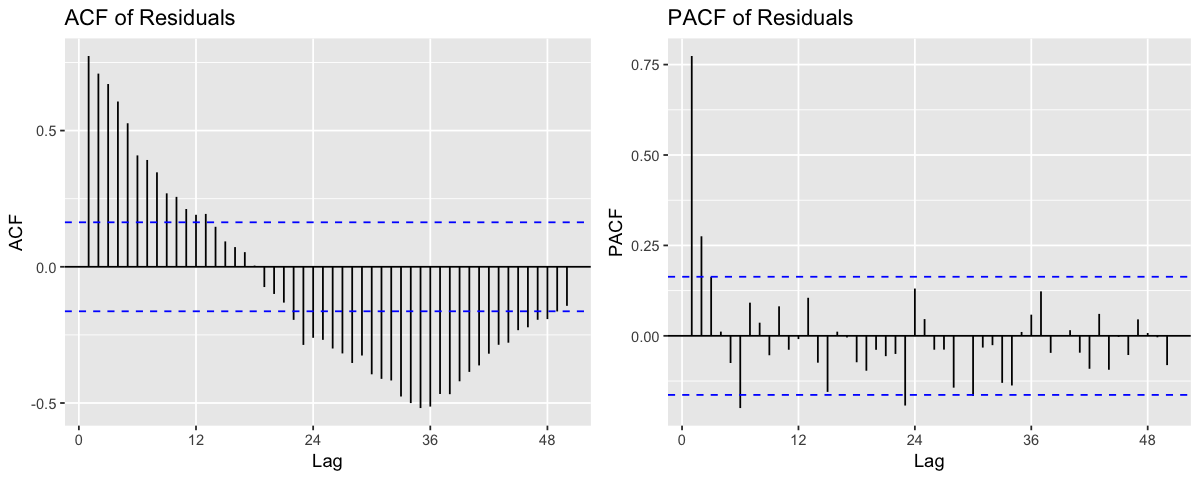

In [24]:
# Check the ACF and PACF
p1 <- ggAcf(resid_ts,lag.max=50)+ggtitle("ACF of Residuals")
p2 <- ggPacf(resid_ts,lag.max=50) + ggtitle("PACF of Residuals")

options(repr.plot.width=10, repr.plot.height=4, repr.plot.pointsize=30)
grid.arrange(p1,p2,nrow=1)

There are plenty of significant autocorrelations. Perhaps we can try differencing and check whether it gives us better results:

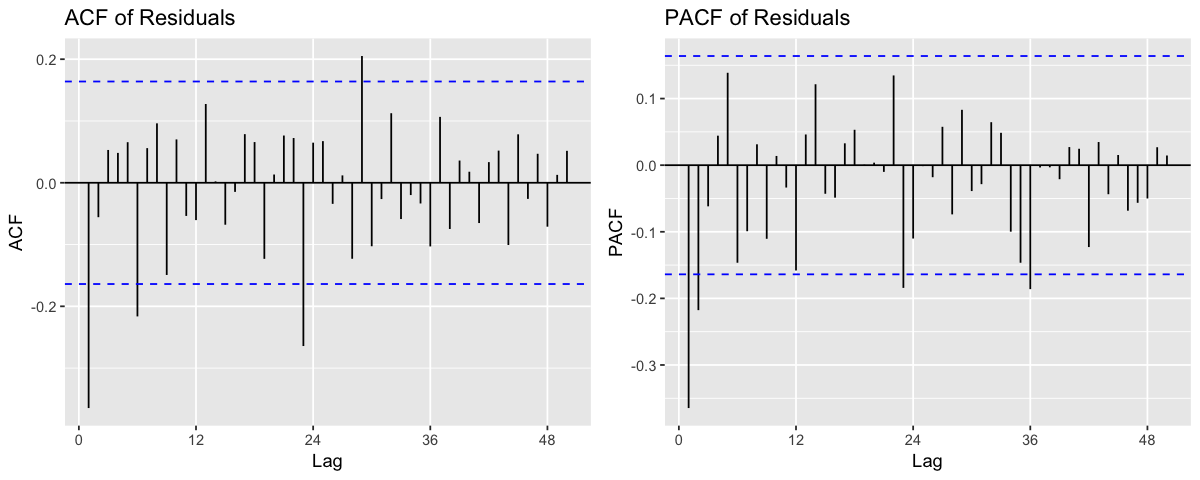

In [25]:
# Check the ACF and PACF
p1 <- ggAcf(diff(resid_ts),lag.max=50) + ggtitle("ACF of Residuals")
p2 <- ggPacf(diff(resid_ts),lag.max=50) + ggtitle("PACF of Residuals")

options(repr.plot.width=10, repr.plot.height=4, repr.plot.pointsize=30)
grid.arrange(p1,p2,nrow=1)

We can then try an $\text{ARIMA}(2,1,6)$ based from the ACF and PACF:

In [26]:
model3 <- Arima(resid, order=c(2,1,6),include.constant=FALSE)
coeftest(model3)


z test of coefficients:

     Estimate Std. Error z value Pr(>|z|)   
ar1 -0.692991   0.222357 -3.1166  0.00183 **
ar2 -0.550877   0.245625 -2.2428  0.02491 * 
ma1  0.251682   0.223972  1.1237  0.26113   
ma2  0.251356   0.194531  1.2921  0.19632   
ma3 -0.203687   0.122086 -1.6684  0.09524 . 
ma4  0.093644   0.089679  1.0442  0.29639   
ma5  0.036802   0.108947  0.3378  0.73552   
ma6 -0.223918   0.103069 -2.1725  0.02982 * 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


Notice that only $\phi_1$, $\phi_2$, and $\theta_6$ are significant. Thus, we can fit an $\text{ARIMA}(2,1,0)\times(0,0,1)_6$ instead.

In [27]:
model4 <- Arima(resid, order=c(2,1,0),seasonal=list(order=c(0,0,1),period=6),include.constant=FALSE)
coeftest(model4)


z test of coefficients:

      Estimate Std. Error z value Pr(>|z|)    
ar1  -0.437952   0.081958 -5.3436 9.11e-08 ***
ar2  -0.186367   0.082987 -2.2457 0.024721 *  
sma1 -0.227315   0.082271 -2.7630 0.005727 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


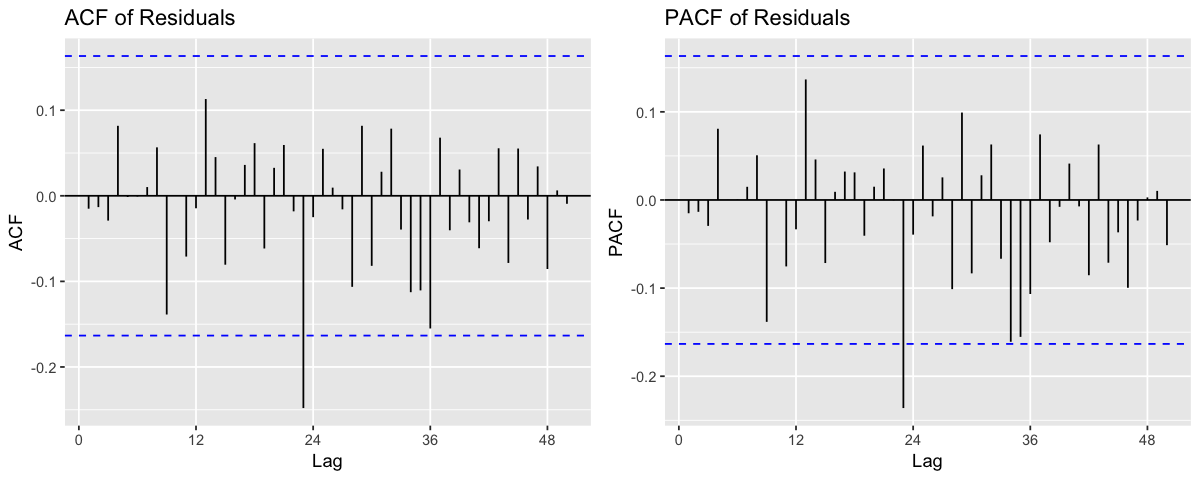

In [28]:
# Check the ACF and PACF
p1 <- ggAcf(model4$residuals,lag.max=50) + ggtitle("ACF of Residuals")
p2 <- ggPacf(model4$residuals,lag.max=50) + ggtitle("PACF of Residuals")

options(repr.plot.width=10, repr.plot.height=4, repr.plot.pointsize=30)
grid.arrange(p1,p2,nrow=1)

In [29]:
# Check Ljung-Box statistic
print(Ljung_Box(model4$residuals))

  lag       LBQ
1  12 0.9529269
2  24 0.7438442
3  36 0.6841681
4  48 0.8897160


We can see from the Ljung-Box statistic that there are no significant autocorrelations at lags 12, 24, 36 and 48.

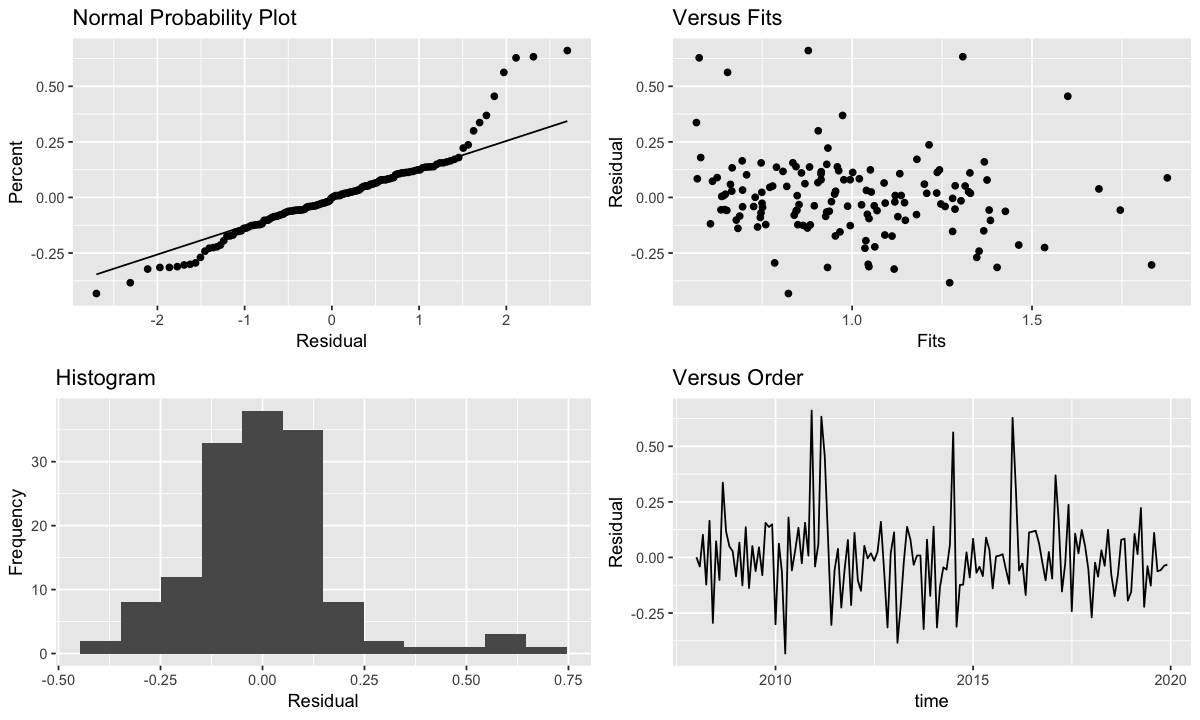

In [30]:
p1 <- ggplot() + 
    geom_qq(aes(sample=as.matrix(model4$residuals))) + 
    geom_qq_line(aes(sample=as.matrix(model4$residuals))) +
    ggtitle("Normal Probability Plot") + 
    xlab("Residual") +
    ylab("Percent")

v_fit = data.frame(Fits=as.matrix(fitted(model4)),
                   Residual=as.matrix(model4$residuals),
                   time=as.Date(time(model4$residuals)))

p2 <- ggplot(v_fit,aes(x=Fits,y=Residual)) + geom_point()+ggtitle("Versus Fits")

p3 <- ggplot(v_fit,aes(x=Residual)) + geom_histogram(bins=12) + ggtitle("Histogram") + ylab("Frequency")

p4 <- ggplot(v_fit,aes(x=time,y=Residual)) + geom_line() + ggtitle("Versus Order")

options(repr.plot.width=10, repr.plot.height=6, repr.plot.pointsize=30)
grid.arrange(p1,p2,p3,p4)

Notice that the constant variance assumption is violated.

So now we generate four forecasts for the ARIMA model and plot the fits, forecasts and the original data together:

In [31]:
forecast_ARIMA <- forecast(model4,h=4,level=95)
forecast_actual <- as.matrix(forecast_ARIMA$mean)*forecast_trend*season_comps[1:4]
forecast_low <- as.matrix(forecast_ARIMA$lower)*forecast_trend*season_comps[1:4]
forecast_high <- as.matrix(forecast_ARIMA$upper)*forecast_trend*season_comps[1:4]
fits_total <- trend_line * rep(season_comps,floor(length(detrend_data)/12))*as.matrix(fitted(model4))

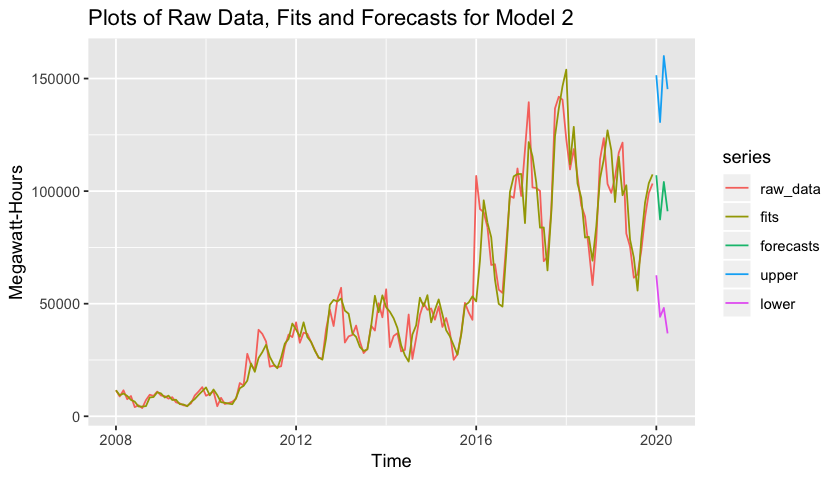

In [32]:
raw_data <- ts(raw_data,start=c(2008,1),deltat=1/12)
fits <- ts(fits_total,start=c(2008,1),deltat=1/12)
forecasts <- ts(forecast_actual,start=c(2020,1),deltat=1/12)
upper <- ts(forecast_high,start=c(2020,1),deltat=1/12)
lower <- ts(forecast_low,start=c(2020,1),deltat=1/12)

options(repr.plot.width=7, repr.plot.height=4, repr.plot.pointsize=30)
comb_ts <- cbind(raw_data,fits,forecasts,upper,lower)
autoplot(comb_ts,main="Plots of Raw Data, Fits and Forecasts for Model 2",ylab="Megawatt-Hours")

In [33]:
acc_meas2 <- accuracy_meas(as.matrix(raw_data),as.matrix(fits))
print(acc_meas2)

      MAPE      MAD      MSD
1 13.47255 5907.678 90936835


# Discussion and Conclusions
So for Model 2, we have $\text{MAPE} = 13.47$, $\text{MAD} = 5907.68$ and $\text{MSD} = 9.09 \times 10^7$. But for model 1, recall that $\text{MAPE} = 14.03$, $\text{MAD} = 6107.95$ and $\text{MSD} = 9.39 \times 10^7$. Thus, in terms of accuracy, model 2 is better. However, model 2 violates the constant variance assumption. If we were to choose a model to be implemented, we would rather choose model 1, as its accuracy measures *are not far* from model 2, and its residuals conform better to the white noise process than model 2.